### Importing libraries

In [1]:
pip install duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.28.2
    Uninstalling requests-2.28.2:
      Successfully uninstalled requests-2.28.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires requests<2.29,>=2.24.0, but you have requests 2.30.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incomp

In [2]:
import warnings
warnings.filterwarnings('ignore')
from fastai.vision.all import *
from fastcore.all import *
from duckduckgo_search import ddg_images
from fastdownload import download_url
from time import sleep
import matplotlib.pyplot as plt

#### Defining a function to search images

In [3]:
def search_images(term, max_images=30):
    print(f'searching for {term}')
    return L(ddg_images(keywords=term,max_results=max_images)).itemgot('image')

#### Checking if our function works as expected

searching for normal_car


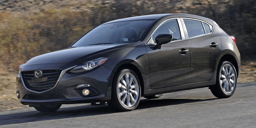

In [4]:
download_url(search_images('normal_car',max_images=1)[0],'normal_car.jpg',show_progress = False)
Image.open('normal_car.jpg').to_thumb(256,256)

searching for damaged_car


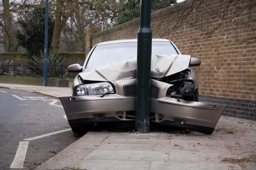

In [5]:
download_url(search_images('damaged_car',max_images=1)[0],'damaged_car.jpg',show_progress = False)
Image.open('damaged_car.jpg').to_thumb(256,256)

In [6]:
searches = 'normal car','damaged car'
path = Path('Normal vs Damaged')

for i in searches:
    dest = path/i
    dest.mkdir(exist_ok = True, parents = True)
    download_images(dest = dest, urls = search_images(i))
    sleep(1)
    download_images(dest = dest, urls = search_images(i))
    
    resize_images(path/i, max_size=400, dest=path/i)

searching for normal car
searching for normal car
searching for damaged car
searching for damaged car


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

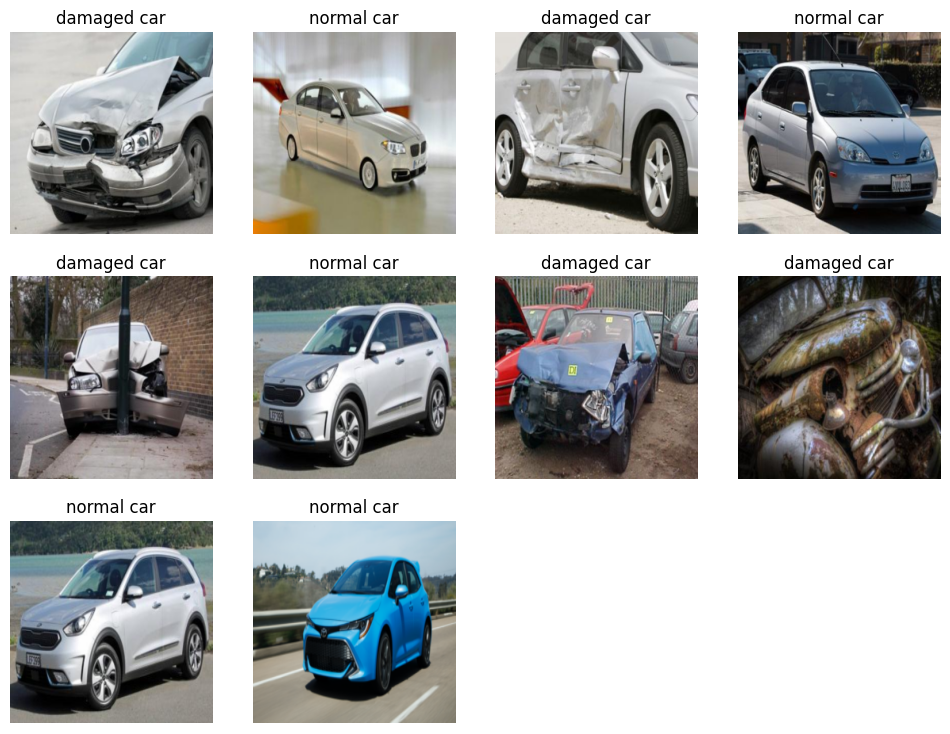

In [8]:
dls = DataBlock(
                blocks = (ImageBlock,CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.3,seed=0),
                get_y = parent_label,
                item_tfms = [Resize(256, method='squish')]).dataloaders(path,bs = 32)

dls.show_batch(max_n = 10)

### Modeling

In [9]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.648260,1.227982,0.531250,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.737073,0.596344,0.250000,00:14
1,0.482108,0.234471,0.125000,00:13
2,0.329923,0.096712,0.062500,00:13
3,0.250536,0.031894,0.000000,00:14
4,0.197045,0.013238,0.000000,00:13
5,0.160996,0.006968,0.000000,00:14
6,0.135253,0.004916,0.000000,00:13
7,0.115941,0.003879,0.000000,00:14
8,0.101111,0.003578,0.000000,00:13
9,0.089246,0.003651,0.000000,00:14


In [10]:
learn.summary()

Sequential (Input shape: 32 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 128 x 128 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 64 x 64   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [11]:
def predict(image):
    is_what,_,probs = learn.predict(image)
    print(f'This is {is_what}')
    print(f'Probability of {is_what} {round(float(probs[_]),ndigits=4)}')
    plt.imshow(Image.open(image).to_thumb(256,256),aspect=0.8)

This is normal car
Probability of normal car 0.6616


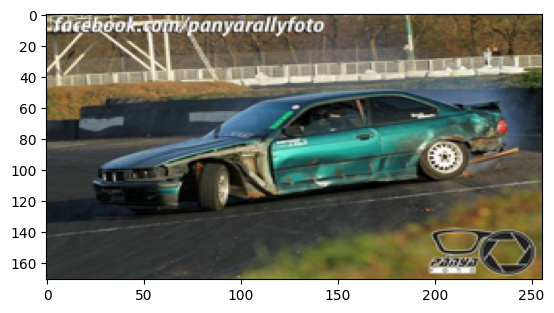

In [12]:
predict('/kaggle/input/tdddad/iu')

This is normal car
Probability of normal car 0.5576


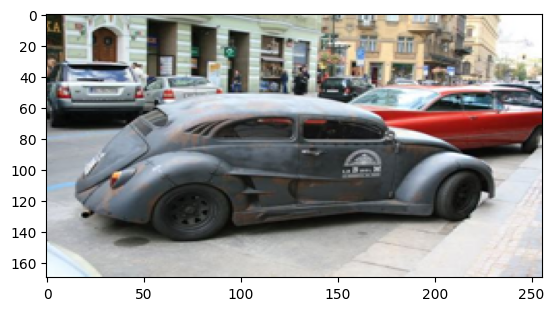

In [13]:
predict('/kaggle/input/test-data/nmm')

This is normal car
Probability of normal car 0.8077


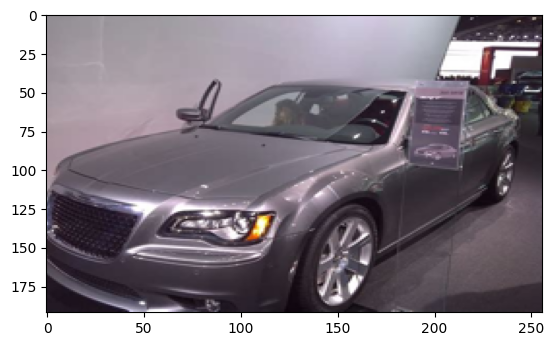

In [14]:
predict('/kaggle/input/test-data/nom')

This is damaged car
Probability of damaged car 0.9003


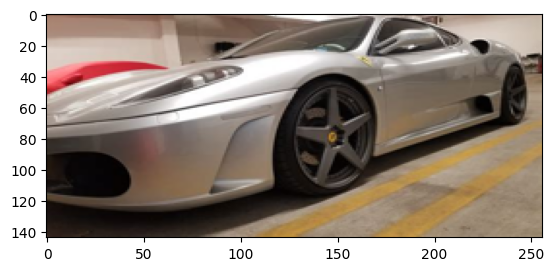

In [15]:
predict('/kaggle/input/test-data/nor')

This is damaged car
Probability of damaged car 0.9983


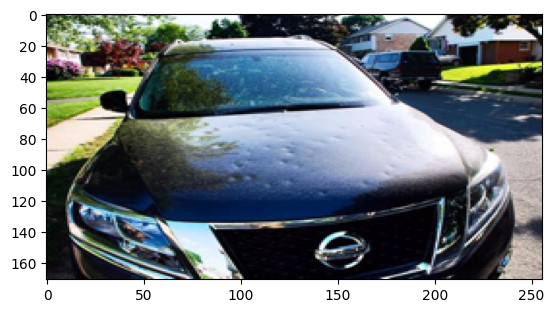

In [16]:
predict('/kaggle/input/test-data/damage')

This is damaged car
Probability of damaged car 0.9988


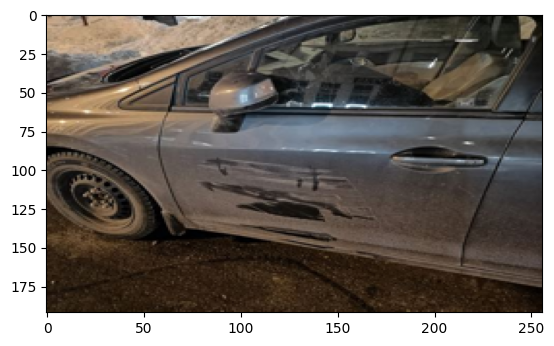

In [17]:
predict('/kaggle/input/test-data/daamage')

This is damaged car
Probability of damaged car 0.9952


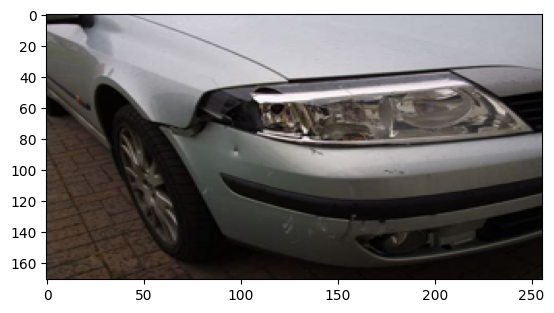

In [18]:
predict('/kaggle/input/test-data/dam4')

In [19]:
learn.export('model.pkl')